In [1]:
#!pip install -U statsmodels
#!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import itertools

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [68]:
df = pd.read_csv(
    '../../datasets/perrin-freres-monthly-champagne.csv',
    index_col='Month',
    skipfooter=2,## se salta las ultimas 2 filas 
    parse_dates=True)#convierte la columna de fechas a formato date 

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_9572\2302113248.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(


In [69]:
df.head()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [70]:
df.shape

(105, 1)

In [71]:
print(df.index.min())
print(df.index.max())

1964-01-01 00:00:00
1972-09-01 00:00:00


In [72]:
df.isna().sum()

Perrin Freres monthly champagne sales millions ?64-?72    0
dtype: int64

In [73]:
df.rename(columns={"Perrin Freres monthly champagne sales millions ?64-?72": "sales"}, inplace=True)

In [74]:
df.index.isna().sum()

0

In [75]:
rango_fechas = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
rango_fechas

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', length=105, freq='MS')

In [76]:
# 2. Usar "difference" para encontrar las diferencias entre este rango y el índice original del *DataFrame*
rango_fechas.difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

<Axes: xlabel='Month', ylabel='sales'>

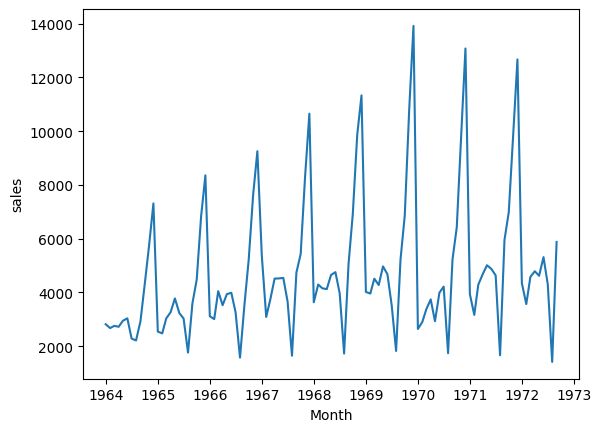

In [77]:
sns.lineplot(df['sales'])

In [78]:
#podemos ver que hay sesonality en nuestra informacion 

In [79]:
df.index.freq = 'MS'

In [80]:
# Assume the forecast horizon we care about is 12
# Validate over 10 steps
h = 12
steps = 10# walk forward steps
Ntest = len(df) - h - steps + 1

In [81]:
print(Ntest)

84


In [82]:
Ntest = 12# how do we define this ? , is it because the seasonal cycle is one year
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [83]:
# boolean series to index df rows---identificamos los indices para cada grupo de datos
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

try walk forward validation to detect the better parameters for the model

## walk forward validation

In [84]:
# Assume the forecast horizon we care about is 12
# Validate over 10 steps
h = 12
steps = 10# walk forward steps
Ntest = len(df) - h - steps + 1

In [85]:
train.index.isna().sum()

0

In [86]:
def walkforward(
    trend_type,
    seasonal_type,
    damped_trend,
    init_method,
    use_boxcox,
    debug=False):

  # store errors
  errors = []
  seen_last = False
  steps_completed = 0

  for end_of_train in range(Ntest, len(df) - h + 1):
    # We don't have to manually "add" the data to our dataset
    # Just index it at the right points - this is a "view" not a "copy"
    # So it doesn't take up any extra space or computation
    train = df.iloc[:end_of_train]
    test = df.iloc[end_of_train:end_of_train + h]

    if test.index[-1] == df.index[-1]:# this is to ensure we have reacht to the end of the data
      seen_last = True
    
    steps_completed += 1

    hw = ExponentialSmoothing(
        train['sales'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=12,
        use_boxcox=use_boxcox)
    res_hw = hw.fit()
    
    # compute error for the forecast horizon
    fcast = res_hw.forecast(h)
    ## cuando falla aparecen nulos el mean square error va a dar error 
    if fcast.isnull().values.any():
        return float('inf')
    error = mean_squared_error(test['sales'], fcast)
    errors.append(error)
  if debug:
    print("seen_last:", seen_last)
    print("steps completed:", steps_completed)

  return np.mean(errors)

In [87]:
walkforward('add', 'add', False, 'legacy-heuristic', 0, debug=True)

seen_last: True
steps completed: 10


268239.23093096295

In [88]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul']
damped_trend_list = [True, False]
init_method_list = [ 'estimated','heuristic', 'legacy-heuristic']#'estimated' eliminamos esta opcion porque nos salia que no se podia estimar con menos de dos seasonal cycles
use_boxcox_list = [True, False, 0]# we should review documentation ti have the cero values corresponding to the log transform

In [89]:
# Iterate through all possible options (i.e. grid search)
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list,
)
for x in itertools.product(*tuple_of_option_lists):
  print(x)

('add', 'add', True, 'estimated', True)
('add', 'add', True, 'estimated', False)
('add', 'add', True, 'estimated', 0)
('add', 'add', True, 'heuristic', True)
('add', 'add', True, 'heuristic', False)
('add', 'add', True, 'heuristic', 0)
('add', 'add', True, 'legacy-heuristic', True)
('add', 'add', True, 'legacy-heuristic', False)
('add', 'add', True, 'legacy-heuristic', 0)
('add', 'add', False, 'estimated', True)
('add', 'add', False, 'estimated', False)
('add', 'add', False, 'estimated', 0)
('add', 'add', False, 'heuristic', True)
('add', 'add', False, 'heuristic', False)
('add', 'add', False, 'heuristic', 0)
('add', 'add', False, 'legacy-heuristic', True)
('add', 'add', False, 'legacy-heuristic', False)
('add', 'add', False, 'legacy-heuristic', 0)
('add', 'mul', True, 'estimated', True)
('add', 'mul', True, 'estimated', False)
('add', 'mul', True, 'estimated', 0)
('add', 'mul', True, 'heuristic', True)
('add', 'mul', True, 'heuristic', False)
('add', 'mul', True, 'heuristic', 0)
('add

In [90]:
# Iterate through all possible options (i.e. grid search)
best_score = float('inf')
best_options = None
for x in itertools.product(*tuple_of_option_lists):
  print(x)
  score = walkforward(*x)

  if score < best_score:
    print("Best score so far:", score)
    best_score = score
    best_options = x

('add', 'add', True, 'estimated', True)
Best score so far: 372672.76539823116
('add', 'add', True, 'estimated', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

Best score so far: 312828.21964688145
('add', 'add', True, 'estimated', 0)
('add', 'add', True, 'heuristic', True)
Best score so far: 306314.28547030577
('add', 'add', True, 'heuristic', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('add', 'add', True, 'heuristic', 0)
('add', 'add', True, 'legacy-heuristic', True)
('add', 'add', True, 'legacy-heuristic', False)
('add', 'add', True, 'legacy-heuristic', 0)
Best score so far: 280492.12117684225
('add', 'add', False, 'estimated', True)
Best score so far: 206029.66725928633
('add', 'add', False, 'estimated', False)
('add', 'add', False, 'estimated', 0)
('add', 'add', False, 'heuristic', True)
Best score so far: 199800.36579802068
('add', 'add', False, 'heuristic', False)
('add', 'add', False, 'heuristic', 0)
('add', 'add', False, 'legacy-heuristic', True)
('add', 'add', False, 'legacy-heuristic', False)
('add', 'add', False, 'legacy-heuristic', 0)
('add', 'mul', True, 'estimated', True)
('add', 'mul', True, 'estimated', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('add', 'mul', True, 'estimated', 0)
('add', 'mul', True, 'heuristic', True)
('add', 'mul', True, 'heuristic', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('add', 'mul', True, 'heuristic', 0)
('add', 'mul', True, 'legacy-heuristic', True)
('add', 'mul', True, 'legacy-heuristic', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('add', 'mul', True, 'legacy-heuristic', 0)
('add', 'mul', False, 'estimated', True)
('add', 'mul', False, 'estimated', False)
('add', 'mul', False, 'estimated', 0)
('add', 'mul', False, 'heuristic', True)
('add', 'mul', False, 'heuristic', False)
('add', 'mul', False, 'heuristic', 0)
('add', 'mul', False, 'legacy-heuristic', True)
('add', 'mul', False, 'legacy-heuristic', False)
('add', 'mul', False, 'legacy-heuristic', 0)
('mul', 'add', True, 'estimated', True)
('mul', 'add', True, 'estimated', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_

('mul', 'add', True, 'estimated', 0)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\h

('mul', 'add', True, 'heuristic', True)
('mul', 'add', True, 'heuristic', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('mul', 'add', True, 'heuristic', 0)
('mul', 'add', True, 'legacy-heuristic', True)
('mul', 'add', True, 'legacy-heuristic', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('mul', 'add', True, 'legacy-heuristic', 0)
('mul', 'add', False, 'estimated', True)
('mul', 'add', False, 'estimated', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('mul', 'add', False, 'estimated', 0)
('mul', 'add', False, 'heuristic', True)
Best score so far: 198683.06573035492
('mul', 'add', False, 'heuristic', False)
('mul', 'add', False, 'heuristic', 0)
('mul', 'add', False, 'legacy-heuristic', True)
('mul', 'add', False, 'legacy-heuristic', False)
('mul', 'add', False, 'legacy-heuristic', 0)
('mul', 'mul', True, 'estimated', True)
('mul', 'mul', True, 'estimated', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('mul', 'mul', True, 'estimated', 0)
('mul', 'mul', True, 'heuristic', True)
('mul', 'mul', True, 'heuristic', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('mul', 'mul', True, 'heuristic', 0)
('mul', 'mul', True, 'legacy-heuristic', True)
('mul', 'mul', True, 'legacy-heuristic', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retval

('mul', 'mul', True, 'legacy-heuristic', 0)
('mul', 'mul', False, 'estimated', True)
('mul', 'mul', False, 'estimated', False)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_

('mul', 'mul', False, 'estimated', 0)


C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\h

('mul', 'mul', False, 'heuristic', True)
('mul', 'mul', False, 'heuristic', False)
('mul', 'mul', False, 'heuristic', 0)
('mul', 'mul', False, 'legacy-heuristic', True)
('mul', 'mul', False, 'legacy-heuristic', False)
('mul', 'mul', False, 'legacy-heuristic', 0)


In [91]:
print("best score:", best_score)

trend_type, seasonal_type, damped_trend, init_method, use_boxcox = best_options
print("trend_type", trend_type)
print("seasonal_type", seasonal_type)
print("damped_trend", damped_trend)
print("init_method", init_method)
print("use_boxcox", use_boxcox)

best score: 198683.06573035492
trend_type mul
seasonal_type add
damped_trend False
init_method heuristic
use_boxcox True


### holt winter sesonal model

In [92]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [93]:
Ntest = 12# how do we define this ? , is it because the seasonal cycle is one year
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [94]:
hw = ExponentialSmoothing(
    train['sales'],
    initialization_method=init_method,
    trend=trend_type,
    damped_trend=damped_trend,
    seasonal=seasonal_type,
    seasonal_periods=12,
    use_boxcox=use_boxcox)
res_hw = hw.fit()

In [95]:
# boolean series to index df rows---identificamos los indices para cada grupo de datos
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [96]:
df.loc[train_idx, 'HoltWintersTrain'] = res_hw.fittedvalues

In [97]:
df.loc[test_idx, 'HoltWintersTest'] = res_hw.forecast(Ntest)

In [98]:
df.head()

,sales,HoltWintersTrain,HoltWintersTest
Month,,,
1964-01-01,2815,2806.774561,NaN
1964-02-01,2672,2547.359951,NaN
1964-03-01,2755,3025.740557,NaN
1964-04-01,2721,3061.349030,NaN
1964-05-01,2946,3281.441091,NaN


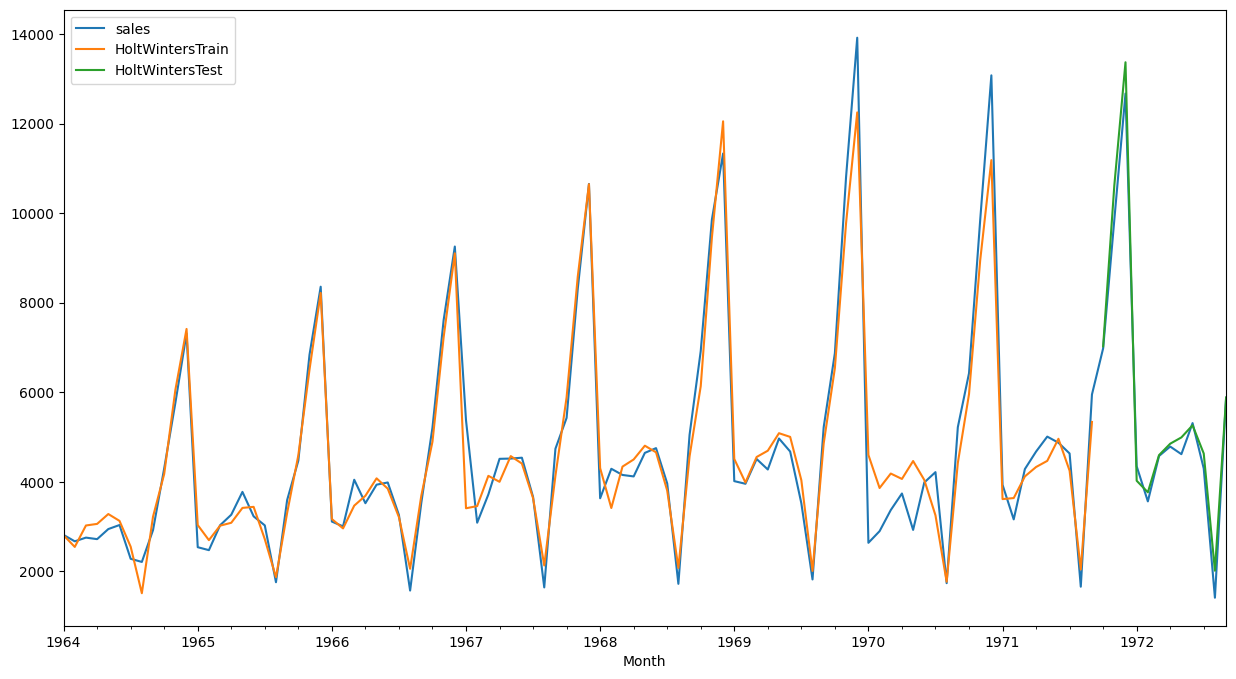

In [99]:
df[['sales', 'HoltWintersTrain', 'HoltWintersTest']].plot(figsize=(15, 8));

In [100]:
r2_score(train['sales'], res_hw.fittedvalues)

0.9441200621012606

In [101]:
r2_score(test['sales'], res_hw.forecast(Ntest))


0.9811168000917069